# Part 2: Exploratory analysis

In [399]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
import math

In [400]:
import warnings
warnings.filterwarnings("ignore")

#### Prep data

In [401]:
df_listings = pd.read_csv("data/listings_CPH.csv")
df_listings.drop(columns=["name","host_id", "neighbourhood_group","license","host_name","last_review"], inplace=True, axis=1)
df_listings.fillna({'reviews_per_month':0}, inplace=True)

# Add dummy vars for the categorical variables
neighbourhood = pd.get_dummies(df_listings['neighbourhood'].str.lower().str.replace(' ', '_'))
df_listings = pd.merge(df_listings, neighbourhood, left_index=True, right_index=True)
df_listings = df_listings.drop('neighbourhood', 1)

room_type = pd.get_dummies(df_listings['room_type'])
df_listings = pd.merge(df_listings, room_type, left_index=True, right_index=True)
df_listings = df_listings.drop('room_type', 1)

df_listings

#SHOULD REMOVE OUTLIERS BASED ON PRICE???? BASED ON OUTLIERS IN ALL COLUMNS!! TROR SPESS MIN NIGHTS OG PRICE HAR NOEN BASERT PÅ NORMALIZZED DATASETT

id  latitude  longitude  price  minimum_nights  \
0                    6983     55.69      12.55    898               3   
1                   26057     55.69      12.58   2600               4   
2                   26473     55.68      12.58   3250               3   
3                   29118     55.67      12.56    725               7   
4                   31094     55.67      12.56   1954               3   
...                   ...       ...        ...    ...             ...   
13810  653494030951422457     55.73      12.57   1250              14   
13811  647809303952891559     55.67      12.46    450               3   
13812  650819220455514228     55.66      12.47    400               1   
13813  658612163688161695     55.73      12.49    850               1   
13814  648436253362373119     55.73      12.52    420               2   

       number_of_reviews  reviews_per_month  calculated_host_listings_count  \
0                    172               1.08                               1   
1                     59               0.55                               1   
2                    300               2.06                               3   
3                     24               0.16                               1   
4                     19               0.13                               1   
...                  ...                ...                             ...   
13810                  0               0.00                               1   
13811                  3               1.01                               1   
13812                  3               1.27                               1   
13813                  0               0.00                               1   
13814                  1               0.37                               2   

       availability_365  number_of_reviews_ltm  ...  nrrebro  sterbro  valby  \
0                     0                      4  ...        1        0      0   
1                   303                      8  ...        0        0      0   
2                    56                      7  ...        0        0      0   
3                    59                      2  ...        0        0      0   
4                     0                      2  ...        0        0      0   
...                 ...                    ...  ...      ...      ...    ...   
13810                 0                      0  ...        0        1      0   
13811                 0                      3  ...        0        0      1   
13812                 0                      3  ...        0        0      1   
13813                 0                      0  ...        0        0      0   
13814                 0                      1  ...        0        0      0   

       vanlse  vesterbro-kongens_enghave  Entire ho    me/apt  \
0           0                          0                    0   
1           0                          0                    0   
2           0                          0                    0   
3           0                          1                    0   
4           0                          1                    0   
...       ...                        ...                  ...   
13810       0                          0                    0   
13811       0                          0                    0   
13812       0                          0                    0   
13813       0                          0                    0   
13814       0                          0                    0   

       Entire home/apt  Hotel room  Private room  Shared room  
0                    1           0             0            0  
1                    1           0             0            0  
2                    1           0             0            0  
3                    1           0             0            0  
4                    1           0             0            0  
...                ...         ...           ...          ...  
13810  

### Exploratory component part 1: Proximity to metro stops, city center (indre by) and top 10 tourist attractions on TripAdvisor as a new features

In [402]:
def distance(origin, destination):
    """
    Calculate the Haversine distance. From: https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude

    Parameters
    ----------
    origin : tuple of float
        (lat, long)
    destination : tuple of float
        (lat, long)

    Returns
    -------
    distance_in_km : float
    """
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371  # km

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c

    return d

#### 1.1: Display interactive scatter of listings in latitude-longitude space 
(To get a feel for the density)<br/>
(The plot below does not show in github online, so a screenshot of the interactive map is added below)

In [403]:
import plotly.express as px
import plotly.io as pio
import plotly.offline as pyo
# Set notebook mode to work in offline
pyo.init_notebook_mode()

In [404]:
api_token = "pk.eyJ1IjoiYmFybGF1ZyIsImEiOiJjbGE2czJqNGcwazJuM3dxenhucXAxb3E1In0.--v3HQgnOhI_fjUHxq0csg"

In [405]:
df = df_listings[["latitude", "longitude"]]
df["color"] =  np.ones(len(df))

fig = px.scatter_mapbox(df, lat="latitude", lon="longitude", width=1100, height=800, color="color")
fig.update_layout(font_size=16,  title={'xanchor': 'center','yanchor': 'top', 'y':0.1, 'x':0.1,}, 
        title_font_size = 24, mapbox_accesstoken=api_token)#, mapbox_style = "mapbox://styles/strym/ckhd00st61aum19noz9h8y8kw")
fig.update_traces(marker=dict(size=6))            
fig.show()

![](interactive_scatter.png)

#### 1.2: Calculate metro proximity for all listings
(For all listings, calculate distance to the *closest* metro stop)

In [406]:
# This dataset contains all bus/train/metrostops in Copenhagen Muncipality
df_stops = pd.read_csv("data/stops.txt")
# We are only interested in longitude and latitude of the stops
df_stops = df_stops.drop(columns=["stop_id","stop_code","stop_desc","zone_id","stop_url","location_type","parent_station","stop_timezone","level_id","wheelchair_boarding","platform_code"], axis=1)
# Remove all rows that does not have (Metro) in its name
df_stops = df_stops[df_stops['stop_name'].str.contains('\(Metro\)')].reset_index()
df_stops = df_stops.rename(columns={"stop_lon": "longitude", "stop_lat": "latitude"})
display(df_stops)

index                   stop_name  longitude  latitude
0      51      Vestamager St. (Metro)      12.58     55.62
1      52         Ørestad St. (Metro)      12.58     55.63
2      53          Sundby St. (Metro)      12.59     55.65
3      54    Bella Center St. (Metro)      12.58     55.64
4      55  Islands Brygge St. (Metro)      12.59     55.66
..    ...                         ...        ...       ...
73  61853    Marmorkirken St. (Metro)      12.59     55.69
74  61854   Gammel Strand St. (Metro)      12.58     55.68
75  61855   Rådhuspladsen St. (Metro)      12.57     55.68
76  62103        Nordhavn St. (Metro)      12.59     55.71
77  62227       Orientkaj St. (Metro)      12.60     55.71

[78 rows x 4 columns]

In [407]:
# For all listings, find distance to all metrostops, choose smallest one as "distance to metro"
metro_locations = [(df_stops["latitude"][i], df_stops["longitude"][i]) for i in range(0, len(df_stops["longitude"]))]
listing_locations = [(df_listings["latitude"][i], df_listings["longitude"][i]) for i in range(0, len(df_listings["longitude"]))]

min_distances = []
for list_loc in listing_locations:
    smallest_dist = math.inf
    for metro_loc in metro_locations:
        dist = distance(list_loc, metro_loc)
        if dist < smallest_dist:
            smallest_dist = dist
    min_distances.append(smallest_dist)

min_distances = np.array(min_distances).T
df_listings["distance to metro"] = min_distances

#### 1.3: Calculate indre by proximity for all listings
(lat, lon) = (55.680193, 12.580757)

In [408]:
# Add distance to indre by column
indre_by_loc = (55.680193, 12.580757) # found manually in google maps
dist_to_ib = [distance(k,indre_by_loc) for k in listing_locations]
df_listings["distance to indre by"] = dist_to_ib

#### 1.4: Calculate proximity to top ten tourist attraction for all listings
(Add proximity to each of the top ten tourist attractions as own features) <br/>
Source: https://no.tripadvisor.com/Attractions-g189541-Activities-oa0-Copenhagen_Zealand.html

In [409]:
top_ten_attractions = {"Nyhavn": (55.679803, 12.591254),
                       "Tivoli": (55.673671, 12.568135),
                       "Rosenborg slot": (55.686170, 12.576271),
                       "Frederiksberg slot": (55.671903, 12.525324),
                       "Vor Frelsers kirke": (55.672714, 12.594642),
                       "Christiansborg slot": (55.676426, 12.580907),
                       "Torvehallerne": (55.683625, 12.570017),
                       "Rundetårn": (55.681274, 12.575775),
                       "Glyptoteket": (55.673056, 12.572730),
                       "Københavns zoo": (55.671863, 12.519988)}

df_tourist_attractions = pd.DataFrame.from_dict(top_ten_attractions, orient='index', columns=["latitude", "longitude"])

for name, loc in top_ten_attractions.items():
    dist_to_attraction_i = [distance(k,loc) for k in listing_locations]
    colname_i = "distance to " + name
    df_listings[colname_i] = dist_to_attraction_i

display(df_listings)

id  latitude  longitude  price  minimum_nights  \
0                    6983     55.69      12.55    898               3   
1                   26057     55.69      12.58   2600               4   
2                   26473     55.68      12.58   3250               3   
3                   29118     55.67      12.56    725               7   
4                   31094     55.67      12.56   1954               3   
...                   ...       ...        ...    ...             ...   
13810  653494030951422457     55.73      12.57   1250              14   
13811  647809303952891559     55.67      12.46    450               3   
13812  650819220455514228     55.66      12.47    400               1   
13813  658612163688161695     55.73      12.49    850               1   
13814  648436253362373119     55.73      12.52    420               2   

       number_of_reviews  reviews_per_month  calculated_host_listings_count  \
0                    172               1.08                               1   
1                     59               0.55                               1   
2                    300               2.06                               3   
3                     24               0.16                               1   
4                     19               0.13                               1   
...                  ...                ...                             ...   
13810                  0               0.00                               1   
13811                  3               1.01                               1   
13812                  3               1.27                               1   
13813                  0               0.00                               1   
13814                  1               0.37                               2   

       availability_365  number_of_reviews_ltm  ...  distance to Nyhavn  \
0                     0                      4  ...                2.84   
1                   303                      8  ...                1.74   
2                    56                      7  ...                1.08   
3                    59                      2  ...                2.51   
4                     0                      2  ...                2.69   
...                 ...                    ...  ...                 ...   
13810                 0                      0  ...                6.01   
13811                 0                      3  ...                8.13   
13812                 0                      3  ...                7.65   
13813                 0                      0  ...                8.62   
13814                 0                      1  ...                7.20   

       distance to Tivoli  distance to Rosenborg slot  \
0                    1.92                        1.81   
1                    2.22                        0.77   
2                    0.53                        1.13   
3                    0.91                        2.22   
4                    1.13                        2.54   
...                   ...                         ...   
13810                6.58                        5.20   
13811                6.61                        7.37   
13812                6.07                        7.02   
13813                8.11                        7.44   
13814                7.05                        6.08   

       distance to Frederiksberg slot  distance to Vor Frelsers kirke  \
0                                2.13                            3.33   
1                                3.98                            2.53   
2                                3.17                            1.26   
3                                1.87                            2.50   
4                                1.97                            2.56   
...                               ...                             ...   
13810                            7.39                            6.83   
13811                      

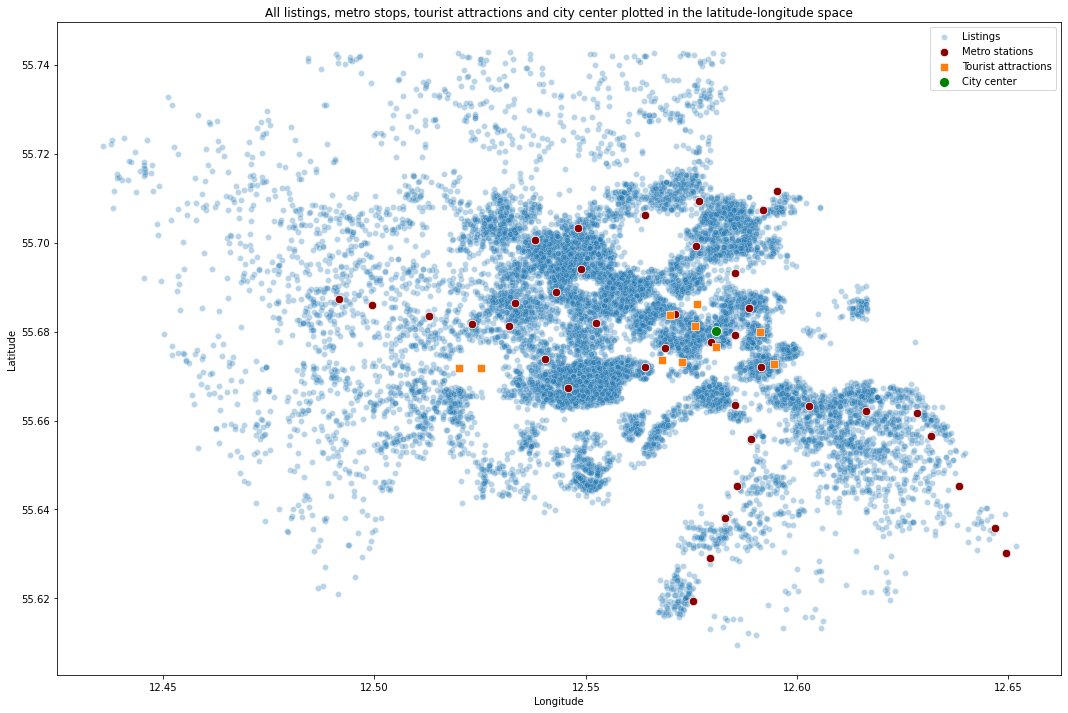

In [410]:
# df needed locally for plotting with seaborn
df_indre_by = pd.DataFrame().from_dict(data={"City center": indre_by_loc}, orient='index', columns=["latitude", "longitude"])
# Display all metro stations, indre by and tourist attractions together with our listings
plt.figure(figsize=(18,12))
sns.scatterplot(data=df_listings, x="longitude", y="latitude", alpha=0.3)
sns.scatterplot(data=df_stops, x="longitude", y="latitude", color="darkred", s=70)
sns.scatterplot(data=df_tourist_attractions, x="longitude", y="latitude",marker="s", s=60)
sns.scatterplot(data=df_indre_by, x="longitude", y="latitude",color='green',marker="o", s=100)
plt.legend(["Listings", "Metro stations", "Tourist attractions", "City center"])
plt.title("All listings, metro stops, tourist attractions and city center plotted in the latitude-longitude space")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

si noe fint om plottet bla at mye ligger inne i sentrum så avstand fra turistattrak kan være samme info som avstand fra indre by elle rnoe sånt

Display listings with colormap based on proximity to metro and city center, to check if it works

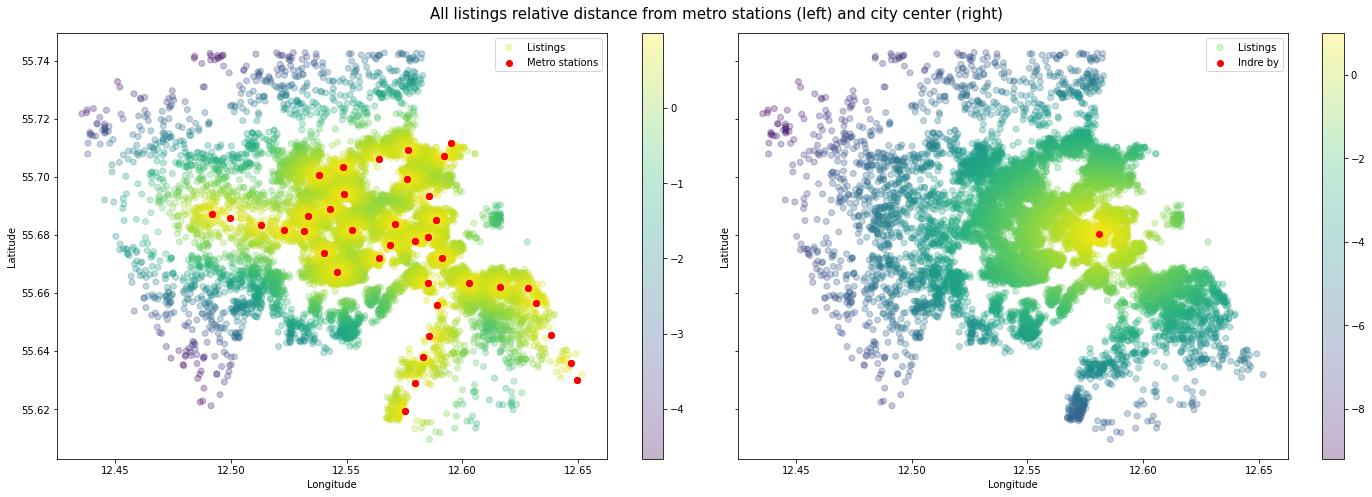

In [411]:
# Display all stations together with our listings
local_col_1 = 1 - df_listings["distance to metro"]

fig, (ax1, ax2) = plt.subplots(1,2,sharey=True,figsize=(20,7))
sc1 = ax1.scatter(df_listings["longitude"], df_listings["latitude"], c=local_col_1, alpha=0.3)
ax1.scatter(df_stops["longitude"], df_stops["latitude"],color='#FF0000')
ax1.legend(["Listings", "Metro stations"])
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")

local_col_2 = 1 - df_listings["distance to indre by"]
sc2 = ax2.scatter(df_listings["longitude"], df_listings["latitude"], c=local_col_2, alpha=0.3)
ax2.scatter(indre_by_loc[1], indre_by_loc[0], color='#FF0000', )
ax2.legend(["Listings", "Indre by"])
ax2.set_xlabel("Longitude")
ax2.set_ylabel("Latitude")

fig.suptitle("All listings relative distance from metro stations (left) and city center (right)", fontsize=15)
fig.colorbar(sc2)
fig.colorbar(sc1)
fig.tight_layout()
plt.show()

#### 1.5: Explore our new columns to see what info they add

In [412]:
df_listings.columns

Index(['id', 'latitude', 'longitude', 'price', 'minimum_nights',
       'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365',
       'number_of_reviews_ltm', 'amager_st', 'amager_vest', 'bispebjerg',
       'brnshj-husum', 'frederiksberg', 'indre_by', 'nrrebro', 'sterbro',
       'valby', 'vanlse', 'vesterbro-kongens_enghave', 'Entire ho    me/apt',
       'Entire home/apt', 'Hotel room', 'Private room', 'Shared room',
       'distance to metro', 'distance to indre by', 'distance to Nyhavn',
       'distance to Tivoli', 'distance to Rosenborg slot',
       'distance to Frederiksberg slot', 'distance to Vor Frelsers kirke',
       'distance to Christiansborg slot', 'distance to Torvehallerne',
       'distance to Rundetårn', 'distance to Glyptoteket',
       'distance to Københavns zoo'],
      dtype='object')

Check distributions

array([[<AxesSubplot: title={'center': 'distance to metro'}>,
        <AxesSubplot: title={'center': 'distance to indre by'}>,
        <AxesSubplot: title={'center': 'distance to Nyhavn'}>],
       [<AxesSubplot: title={'center': 'distance to Tivoli'}>,
        <AxesSubplot: title={'center': 'distance to Rosenborg slot'}>,
        <AxesSubplot: title={'center': 'distance to Frederiksberg slot'}>],
       [<AxesSubplot: title={'center': 'distance to Vor Frelsers kirke'}>,
        <AxesSubplot: title={'center': 'distance to Christiansborg slot'}>,
        <AxesSubplot: title={'center': 'distance to Torvehallerne'}>],
       [<AxesSubplot: title={'center': 'distance to Rundetårn'}>,
        <AxesSubplot: title={'center': 'distance to Glyptoteket'}>,
        <AxesSubplot: title={'center': 'distance to Københavns zoo'}>]],
      dtype=object)

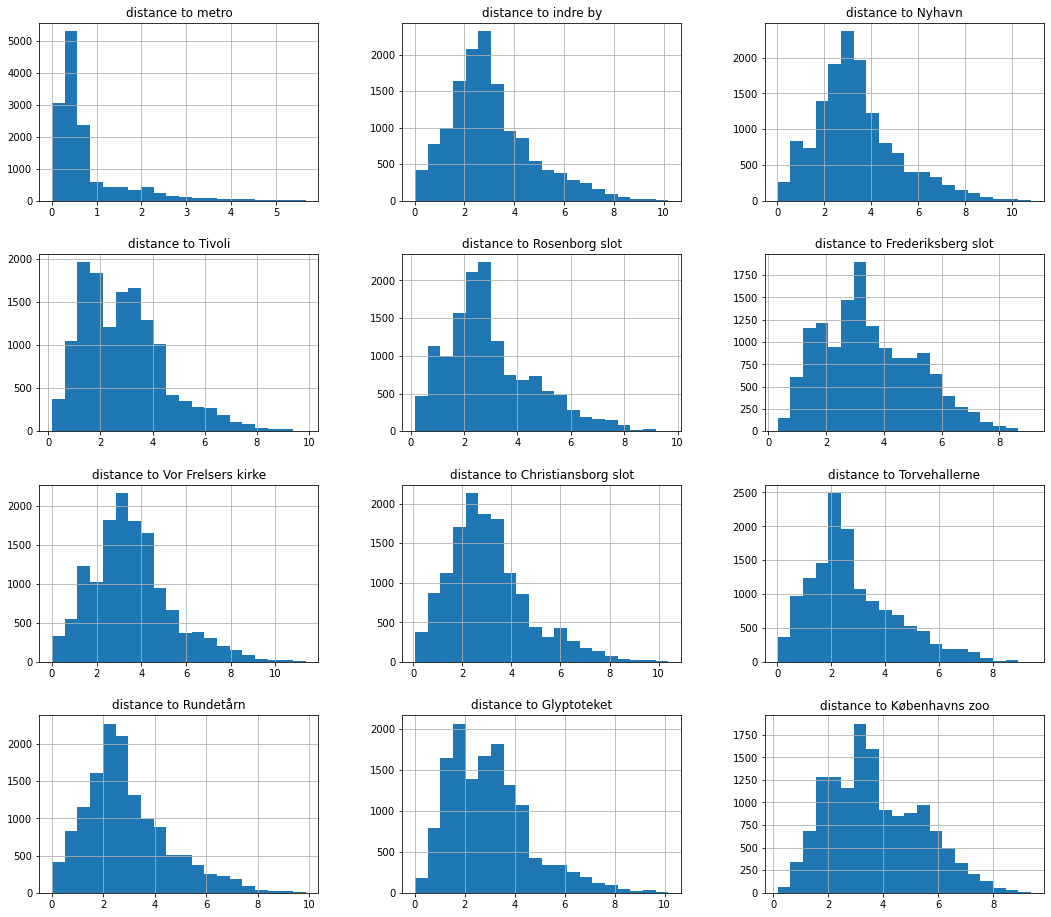

In [413]:
df_ = df_listings[['distance to metro', 'distance to indre by',
       'distance to Nyhavn', 'distance to Tivoli',
       'distance to Rosenborg slot', 'distance to Frederiksberg slot',
       'distance to Vor Frelsers kirke', 'distance to Christiansborg slot',
       'distance to Torvehallerne', 'distance to Rundetårn',
       'distance to Glyptoteket', 'distance to Københavns zoo']]
df_.hist(figsize=(18,16), bins=20)

kommenter histogram

Check correlations between our new variables and the price of the listings

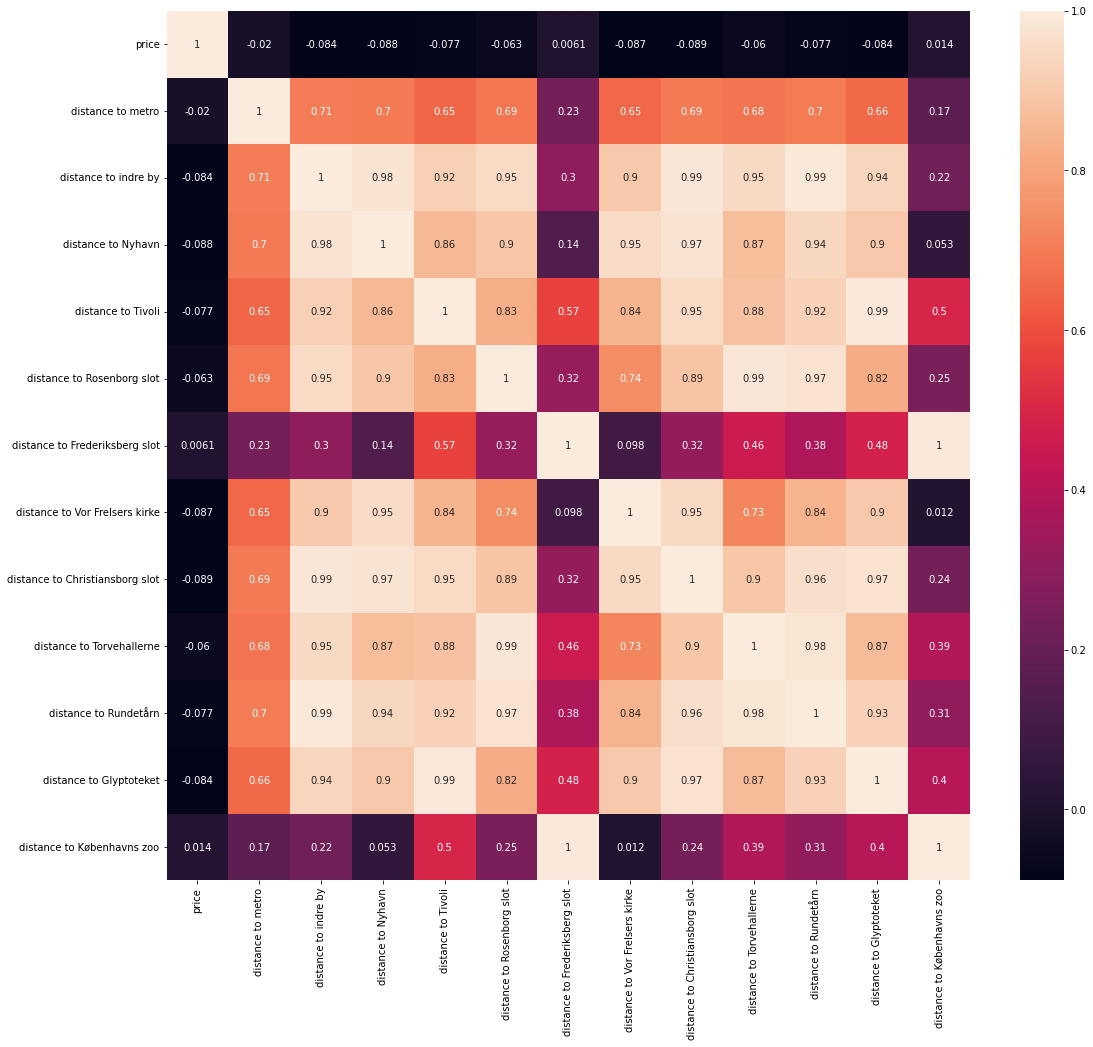

In [414]:
df_= df_listings[['price','distance to metro', 'distance to indre by',
       'distance to Nyhavn', 'distance to Tivoli',
       'distance to Rosenborg slot', 'distance to Frederiksberg slot',
       'distance to Vor Frelsers kirke', 'distance to Christiansborg slot',
       'distance to Torvehallerne', 'distance to Rundetårn',
       'distance to Glyptoteket', 'distance to Københavns zoo']]
plt.figure(figsize=(18,16))
sns.heatmap(df_.corr(), annot=True)
plt.show()

As one can see, our new variables does not correlate with the price of the listings. The only thing we can take from the correlation matrix above is that almost all tourist attractions except from københavn zoo and frederiksber slot, lies close to the city center, which we knew from before. Also, the metro proximity correlates less with all the tourist attractions than city center proximity - this is expected as almost all tourist attractions are located near the city ceter, while the metro stops are more spread out across the whole city.

For comparison, we do the correlation between the 'old' variables once more:

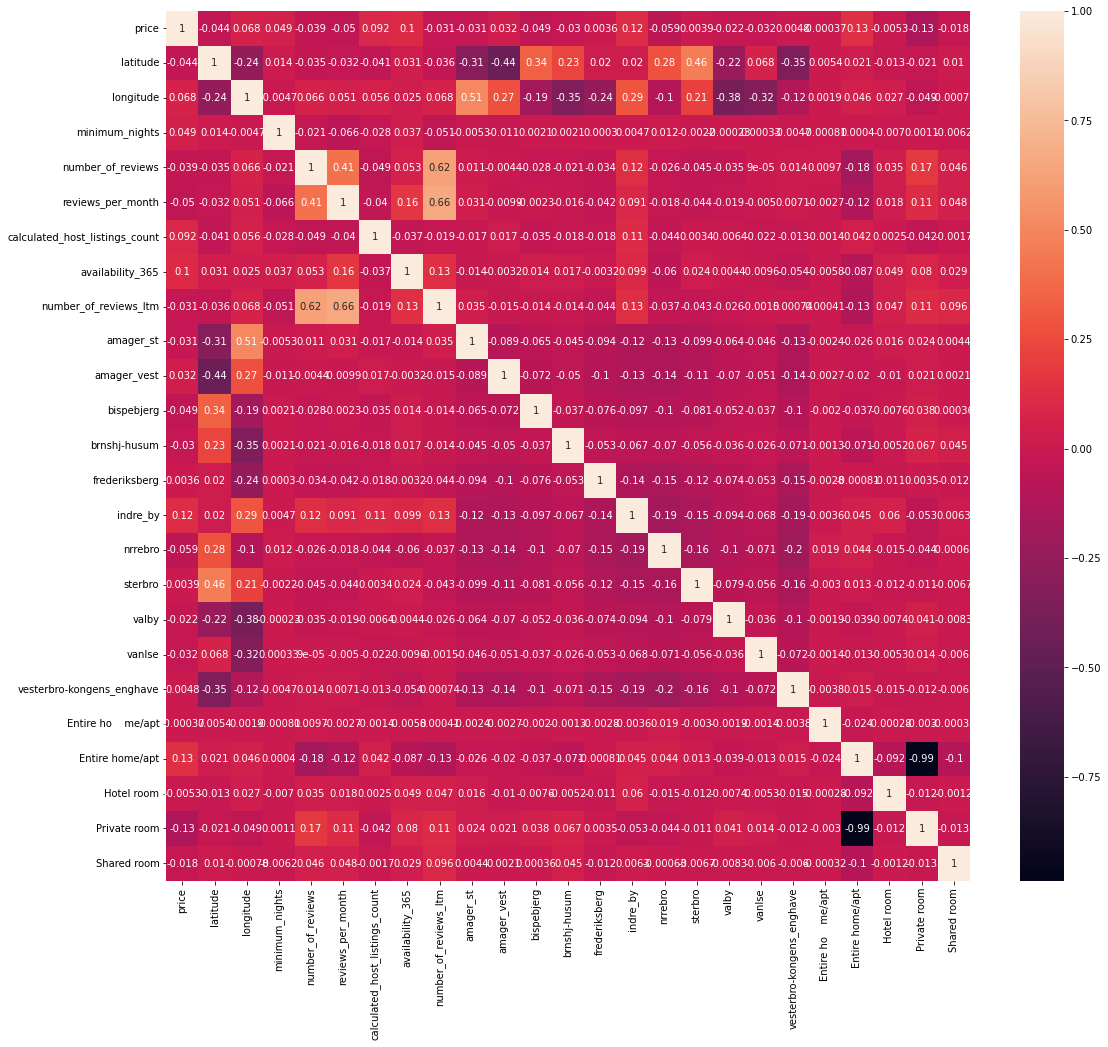

In [415]:
df_= df_listings[['price', 'latitude', 'longitude', 'minimum_nights',
       'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365',
       'number_of_reviews_ltm', 'amager_st', 'amager_vest', 'bispebjerg',
       'brnshj-husum', 'frederiksberg', 'indre_by', 'nrrebro', 'sterbro',
       'valby', 'vanlse', 'vesterbro-kongens_enghave', 'Entire ho    me/apt',
       'Entire home/apt', 'Hotel room', 'Private room', 'Shared room']]
plt.figure(figsize=(18,16))
sns.heatmap(df_.corr(), annot=True)
plt.show()

This does also show no high correlations, but the price do correlate more with e.g. the "Entire home/apt" and "indre by"-column than it does with our new features. We can not base our whole analysis on the correlations between the variables, but this is a good indicator that it may be hard to predict the price of a given listing just based off our newly added features. However, we will quantify this in the classification part.

### Exploratory component part 2: Clustering and classification

#### 2.1: Classification with our new variables
Try classification to see if it is possible to perform better than in the classification part with just the new columns that describe proximities to center, metro and tourist attractions.

Prepare training and testing set, normalize data and create binary target variable

In [416]:

# create target variable
threshold = df_listings["price"].median()
y = [1 if y_i > threshold else 0 for y_i in df_listings["price"]]


X = df_listings.drop(columns=["id","price"], axis=1)
# Normalize numerical columns
normalize_cols = ['longitude', 'latitude', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 
       'number_of_reviews_ltm', 'distance to metro', 'distance to indre by',
       'distance to Nyhavn', 'distance to Tivoli',
       'distance to Rosenborg slot', 'distance to Frederiksberg slot',
       'distance to Vor Frelsers kirke', 'distance to Christiansborg slot',
       'distance to Torvehallerne', 'distance to Rundetårn',
       'distance to Glyptoteket', 'distance to Københavns zoo']

X_normalized = X.copy()
X_normalized[normalize_cols] = (X[normalize_cols] - X[normalize_cols].min()) / (X[normalize_cols].max() - X[normalize_cols].min())
X_normalized

latitude  longitude  minimum_nights  number_of_reviews  \
0          0.58       0.52            0.00               0.24   
1          0.63       0.65            0.00               0.08   
2          0.50       0.65            0.00               0.42   
3          0.46       0.55            0.01               0.03   
4          0.43       0.55            0.00               0.03   
...         ...        ...             ...                ...   
13810      0.93       0.63            0.01               0.00   
13811      0.44       0.13            0.00               0.00   
13812      0.38       0.18            0.00               0.00   
13813      0.91       0.24            0.00               0.00   
13814      0.91       0.40            0.00               0.00   

       reviews_per_month  calculated_host_listings_count  availability_365  \
0                   0.04                            0.00              0.00   
1                   0.02                            0.00              0.83   
2                   0.09                            0.01              0.15   
3                   0.01                            0.00              0.16   
4                   0.01                            0.00              0.00   
...                  ...                             ...               ...   
13810               0.00                            0.00              0.00   
13811               0.04                            0.00              0.00   
13812               0.05                            0.00              0.00   
13813               0.00                            0.00              0.00   
13814               0.02                            0.01              0.00   

       number_of_reviews_ltm  amager_st  amager_vest  ...  distance to Nyhavn  \
0                       0.01          0            0  ...                0.26   
1                       0.02          0            0  ...                0.16   
2                       0.01          0            0  ...                0.10   
3                       0.00          0            0  ...                0.23   
4                       0.00          0            0  ...                0.25   
...                      ...        ...          ...  ...                 ...   
13810                   0.00          0            0  ...                0.56   
13811                   0.01          0            0  ...                0.75   
13812                   0.01          0            0  ...                0.71   
13813                   0.00          0            0  ...                0.80   
13814                   0.00          0            0  ...                0.67   

       distance to Tivoli  distance to Rosenborg slot  \
0                    0.18                        0.17   
1                    0.21                        0.06   
2                    0.04                        0.10   
3                    0.08                        0.22   
4                    0.10                        0.25   
...                   ...                         ...   
13810                0.66                        0.53   
13811                0.66                        0.76   
13812                0.61                        0.72   
13813                0.82                        0.77   
13814                0.71                        0.62   

       distance to Frederiksberg slot  distance to Vor Frelsers kirke  \
0                                0.21                            0.29   
1                                0.42                            0.22   
2                                0.33                            0.11   
3                                0.18                            0.22   
4                                0.19                            0.22   
...                               ...                             ...   
13810                            0.81                            0.60   
13811                            0.41          

In [417]:
X

latitude  longitude  minimum_nights  number_of_reviews  \
0         55.69      12.55               3                172   
1         55.69      12.58               4                 59   
2         55.68      12.58               3                300   
3         55.67      12.56               7                 24   
4         55.67      12.56               3                 19   
...         ...        ...             ...                ...   
13810     55.73      12.57              14                  0   
13811     55.67      12.46               3                  3   
13812     55.66      12.47               1                  3   
13813     55.73      12.49               1                  0   
13814     55.73      12.52               2                  1   

       reviews_per_month  calculated_host_listings_count  availability_365  \
0                   1.08                               1                 0   
1                   0.55                               1               303   
2                   2.06                               3                56   
3                   0.16                               1                59   
4                   0.13                               1                 0   
...                  ...                             ...               ...   
13810               0.00                               1                 0   
13811               1.01                               1                 0   
13812               1.27                               1                 0   
13813               0.00                               1                 0   
13814               0.37                               2                 0   

       number_of_reviews_ltm  amager_st  amager_vest  ...  distance to Nyhavn  \
0                          4          0            0  ...                2.84   
1                          8          0            0  ...                1.74   
2                          7          0            0  ...                1.08   
3                          2          0            0  ...                2.51   
4                          2          0            0  ...                2.69   
...                      ...        ...          ...  ...                 ...   
13810                      0          0            0  ...                6.01   
13811                      3          0            0  ...                8.13   
13812                      3          0            0  ...                7.65   
13813                      0          0            0  ...                8.62   
13814                      1          0            0  ...                7.20   

       distance to Tivoli  distance to Rosenborg slot  \
0                    1.92                        1.81   
1                    2.22                        0.77   
2                    0.53                        1.13   
3                    0.91                        2.22   
4                    1.13                        2.54   
...                   ...                         ...   
13810                6.58                        5.20   
13811                6.61                        7.37   
13812                6.07                        7.02   
13813                8.11                        7.44   
13814                7.05                        6.08   

       distance to Frederiksberg slot  distance to Vor Frelsers kirke  \
0                                2.13                            3.33   
1                                3.98                            2.53   
2                                3.17                            1.26   
3                                1.87                            2.50   
4                                1.97                            2.56   
...                               ...                             ...   
13810                            7.39                            6.83   
13811                            3.92          

In [367]:
# Check lazypredict to see what classifiers perform best on our current split:
from lazypredict.Supervised import LazyClassifier

X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=.33, random_state=123)

clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)

print(models)

100%|██████████| 29/29 [01:16<00:00,  2.64s/it]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
LGBMClassifier                     0.72               0.72     0.72      0.72   
XGBClassifier                      0.71               0.71     0.71      0.71   
RandomForestClassifier             0.70               0.70     0.70      0.70   
AdaBoostClassifier                 0.70               0.70     0.70      0.70   
ExtraTreesClassifier               0.69               0.69     0.69      0.69   
SVC                                0.69               0.69     0.69      0.69   
NuSVC                              0.68               0.68     0.68      0.68   
LogisticRegression                 0.68               0.68     0.68      0.68   
RidgeClassifierCV                  0.68               0.68     0.68      0.68   
RidgeClassifier                    0.68               0.68     0.68      0.68   
CalibratedClassifierCV      

In [368]:
# Check lazypredict to see what classifiers perform best on our current split:
from lazypredict.Supervised import LazyClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=123)

clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)

print(models)

100%|██████████| 29/29 [01:08<00:00,  2.35s/it]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
LGBMClassifier                     0.72               0.72     0.72      0.72   
XGBClassifier                      0.71               0.71     0.71      0.71   
RandomForestClassifier             0.70               0.70     0.70      0.70   
AdaBoostClassifier                 0.70               0.70     0.70      0.70   
ExtraTreesClassifier               0.69               0.69     0.69      0.69   
SVC                                0.69               0.69     0.69      0.69   
NuSVC                              0.68               0.68     0.68      0.68   
LogisticRegression                 0.68               0.68     0.68      0.68   
RidgeClassifierCV                  0.68               0.68     0.68      0.68   
RidgeClassifier                    0.68               0.68     0.68      0.68   
CalibratedClassifierCV      

We actually get the same results without mormalizing our columns. However, these results are not particularly good. We will now try to implement clustering to further improve the classification.

#### 2.2: Clustering

Now try clustering to see how unsupervised learning might differentiate our data. We may project the clusters in the lat lon space:

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, -1}


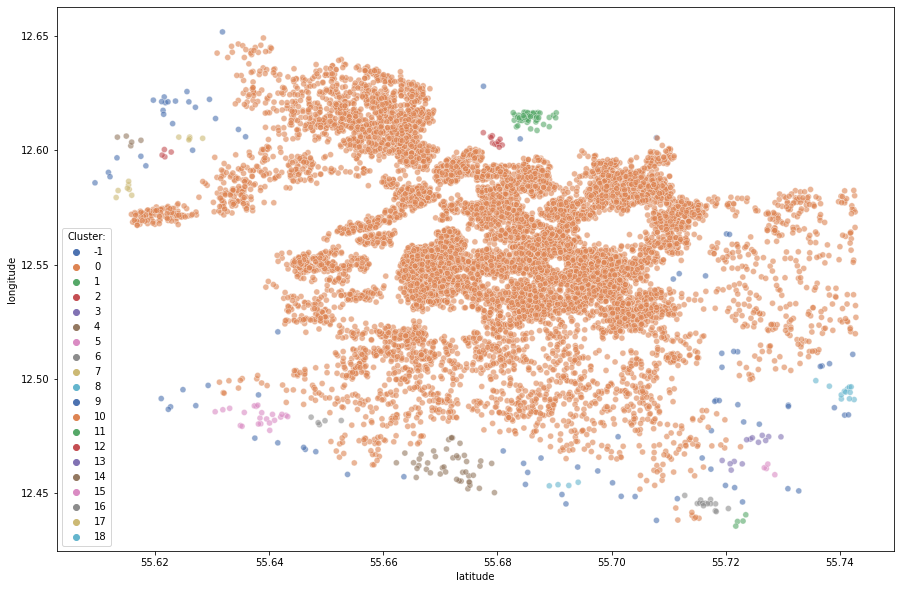

In [369]:
# DBSCAN:
from sklearn.cluster import DBSCAN

points = df_listings[["latitude", "longitude"]]

dbs=DBSCAN(eps=0.0035, min_samples=4)
dbs.fit(points)
print(set(dbs.labels_)) # set of all clusters

plt.figure(figsize=(15,10))
p = sns.scatterplot(data=points, x="latitude", y="longitude", hue=dbs.labels_, legend="full", palette="deep", alpha=.6)
plt.legend(title='Cluster:')
plt.show()

This cant help as much. The listings are really dense so it just creates a large central cluster and assign some listings to other clusters or outliers. We try kmeans.

In [418]:
X_normalized

latitude  longitude  minimum_nights  number_of_reviews  \
0          0.58       0.52            0.00               0.24   
1          0.63       0.65            0.00               0.08   
2          0.50       0.65            0.00               0.42   
3          0.46       0.55            0.01               0.03   
4          0.43       0.55            0.00               0.03   
...         ...        ...             ...                ...   
13810      0.93       0.63            0.01               0.00   
13811      0.44       0.13            0.00               0.00   
13812      0.38       0.18            0.00               0.00   
13813      0.91       0.24            0.00               0.00   
13814      0.91       0.40            0.00               0.00   

       reviews_per_month  calculated_host_listings_count  availability_365  \
0                   0.04                            0.00              0.00   
1                   0.02                            0.00              0.83   
2                   0.09                            0.01              0.15   
3                   0.01                            0.00              0.16   
4                   0.01                            0.00              0.00   
...                  ...                             ...               ...   
13810               0.00                            0.00              0.00   
13811               0.04                            0.00              0.00   
13812               0.05                            0.00              0.00   
13813               0.00                            0.00              0.00   
13814               0.02                            0.01              0.00   

       number_of_reviews_ltm  amager_st  amager_vest  ...  distance to Nyhavn  \
0                       0.01          0            0  ...                0.26   
1                       0.02          0            0  ...                0.16   
2                       0.01          0            0  ...                0.10   
3                       0.00          0            0  ...                0.23   
4                       0.00          0            0  ...                0.25   
...                      ...        ...          ...  ...                 ...   
13810                   0.00          0            0  ...                0.56   
13811                   0.01          0            0  ...                0.75   
13812                   0.01          0            0  ...                0.71   
13813                   0.00          0            0  ...                0.80   
13814                   0.00          0            0  ...                0.67   

       distance to Tivoli  distance to Rosenborg slot  \
0                    0.18                        0.17   
1                    0.21                        0.06   
2                    0.04                        0.10   
3                    0.08                        0.22   
4                    0.10                        0.25   
...                   ...                         ...   
13810                0.66                        0.53   
13811                0.66                        0.76   
13812                0.61                        0.72   
13813                0.82                        0.77   
13814                0.71                        0.62   

       distance to Frederiksberg slot  distance to Vor Frelsers kirke  \
0                                0.21                            0.29   
1                                0.42                            0.22   
2                                0.33                            0.11   
3                                0.18                            0.22   
4                                0.19                            0.22   
...                               ...                             ...   
13810                            0.81                            0.60   
13811                            0.41          

In [419]:
X

latitude  longitude  minimum_nights  number_of_reviews  \
0         55.69      12.55               3                172   
1         55.69      12.58               4                 59   
2         55.68      12.58               3                300   
3         55.67      12.56               7                 24   
4         55.67      12.56               3                 19   
...         ...        ...             ...                ...   
13810     55.73      12.57              14                  0   
13811     55.67      12.46               3                  3   
13812     55.66      12.47               1                  3   
13813     55.73      12.49               1                  0   
13814     55.73      12.52               2                  1   

       reviews_per_month  calculated_host_listings_count  availability_365  \
0                   1.08                               1                 0   
1                   0.55                               1               303   
2                   2.06                               3                56   
3                   0.16                               1                59   
4                   0.13                               1                 0   
...                  ...                             ...               ...   
13810               0.00                               1                 0   
13811               1.01                               1                 0   
13812               1.27                               1                 0   
13813               0.00                               1                 0   
13814               0.37                               2                 0   

       number_of_reviews_ltm  amager_st  amager_vest  ...  distance to Nyhavn  \
0                          4          0            0  ...                2.84   
1                          8          0            0  ...                1.74   
2                          7          0            0  ...                1.08   
3                          2          0            0  ...                2.51   
4                          2          0            0  ...                2.69   
...                      ...        ...          ...  ...                 ...   
13810                      0          0            0  ...                6.01   
13811                      3          0            0  ...                8.13   
13812                      3          0            0  ...                7.65   
13813                      0          0            0  ...                8.62   
13814                      1          0            0  ...                7.20   

       distance to Tivoli  distance to Rosenborg slot  \
0                    1.92                        1.81   
1                    2.22                        0.77   
2                    0.53                        1.13   
3                    0.91                        2.22   
4                    1.13                        2.54   
...                   ...                         ...   
13810                6.58                        5.20   
13811                6.61                        7.37   
13812                6.07                        7.02   
13813                8.11                        7.44   
13814                7.05                        6.08   

       distance to Frederiksberg slot  distance to Vor Frelsers kirke  \
0                                2.13                            3.33   
1                                3.98                            2.53   
2                                3.17                            1.26   
3                                1.87                            2.50   
4                                1.97                            2.56   
...                               ...                             ...   
13810                            7.39                            6.83   
13811                            3.92          

latitude  longitude  minimum_nights  number_of_reviews  \
0          0.58       0.52            0.00               0.24   
1          0.63       0.65            0.00               0.08   
2          0.50       0.65            0.00               0.42   
3          0.46       0.55            0.01               0.03   
4          0.43       0.55            0.00               0.03   
...         ...        ...             ...                ...   
13810      0.93       0.63            0.01               0.00   
13811      0.44       0.13            0.00               0.00   
13812      0.38       0.18            0.00               0.00   
13813      0.91       0.24            0.00               0.00   
13814      0.91       0.40            0.00               0.00   

       reviews_per_month  calculated_host_listings_count  availability_365  \
0                   0.04                            0.00              0.00   
1                   0.02                            0.00              0.83   
2                   0.09                            0.01              0.15   
3                   0.01                            0.00              0.16   
4                   0.01                            0.00              0.00   
...                  ...                             ...               ...   
13810               0.00                            0.00              0.00   
13811               0.04                            0.00              0.00   
13812               0.05                            0.00              0.00   
13813               0.00                            0.00              0.00   
13814               0.02                            0.01              0.00   

       number_of_reviews_ltm  amager_st  amager_vest  ...  distance to Tivoli  \
0                       0.01          0            0  ...                0.18   
1                       0.02          0            0  ...                0.21   
2                       0.01          0            0  ...                0.04   
3                       0.00          0            0  ...                0.08   
4                       0.00          0            0  ...                0.10   
...                      ...        ...          ...  ...                 ...   
13810                   0.00          0            0  ...                0.66   
13811                   0.01          0            0  ...                0.66   
13812                   0.01          0            0  ...                0.61   
13813                   0.00          0            0  ...                0.82   
13814                   0.00          0            0  ...                0.71   

       distance to Rosenborg slot  distance to Frederiksberg slot  \
0                            0.17                            0.21   
1                            0.06                            0.42   
2                            0.10                            0.33   
3                            0.22                            0.18   
4                            0.25                            0.19   
...                           ...                             ...   
13810                        0.53                            0.81   
13811                        0.76                            0.41   
13812                        0.72                            0.36   
13813                        0.77                            0.76   
13814                        0.62                            0.72   

       distance to Vor Frelsers kirke  distance to Christiansborg slot  \
0                                0.29                             0.22   
1                                0.22                             0.18   
2                                0.11                             0.03   
3                                0.22                             0.16   
4                                0.22                             0.18   
...                               ...      

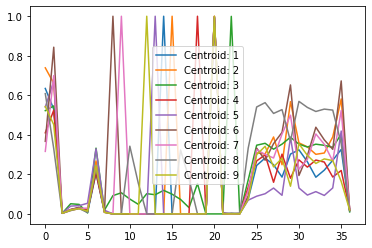

latitude  longitude  minimum_nights  number_of_reviews  \
0          0.58       0.52            0.00               0.24   
1          0.63       0.65            0.00               0.08   
2          0.50       0.65            0.00               0.42   
3          0.46       0.55            0.01               0.03   
4          0.43       0.55            0.00               0.03   
...         ...        ...             ...                ...   
13810      0.93       0.63            0.01               0.00   
13811      0.44       0.13            0.00               0.00   
13812      0.38       0.18            0.00               0.00   
13813      0.91       0.24            0.00               0.00   
13814      0.91       0.40            0.00               0.00   

       reviews_per_month  calculated_host_listings_count  availability_365  \
0                   0.04                            0.00              0.00   
1                   0.02                            0.00              0.83   
2                   0.09                            0.01              0.15   
3                   0.01                            0.00              0.16   
4                   0.01                            0.00              0.00   
...                  ...                             ...               ...   
13810               0.00                            0.00              0.00   
13811               0.04                            0.00              0.00   
13812               0.05                            0.00              0.00   
13813               0.00                            0.00              0.00   
13814               0.02                            0.01              0.00   

       number_of_reviews_ltm  amager_st  amager_vest  ...  distance to Nyhavn  \
0                       0.01          0            0  ...                0.26   
1                       0.02          0            0  ...                0.16   
2                       0.01          0            0  ...                0.10   
3                       0.00          0            0  ...                0.23   
4                       0.00          0            0  ...                0.25   
...                      ...        ...          ...  ...                 ...   
13810                   0.00          0            0  ...                0.56   
13811                   0.01          0            0  ...                0.75   
13812                   0.01          0            0  ...                0.71   
13813                   0.00          0            0  ...                0.80   
13814                   0.00          0            0  ...                0.67   

       distance to Tivoli  distance to Rosenborg slot  \
0                    0.18                        0.17   
1                    0.21                        0.06   
2                    0.04                        0.10   
3                    0.08                        0.22   
4                    0.10                        0.25   
...                   ...                         ...   
13810                0.66                        0.53   
13811                0.66                        0.76   
13812                0.61                        0.72   
13813                0.82                        0.77   
13814                0.71                        0.62   

       distance to Frederiksberg slot  distance to Vor Frelsers kirke  \
0                                0.21                            0.29   
1                                0.42                            0.22   
2                                0.33                            0.11   
3                                0.18                            0.22   
4                                0.19                            0.22   
...                               ...                             ...   
13810                            0.81                            0.60   
13811                            0.41          

latitude  longitude  minimum_nights  number_of_reviews  \
0         55.69      12.55               3                172   
1         55.69      12.58               4                 59   
2         55.68      12.58               3                300   
3         55.67      12.56               7                 24   
4         55.67      12.56               3                 19   
...         ...        ...             ...                ...   
13810     55.73      12.57              14                  0   
13811     55.67      12.46               3                  3   
13812     55.66      12.47               1                  3   
13813     55.73      12.49               1                  0   
13814     55.73      12.52               2                  1   

       reviews_per_month  calculated_host_listings_count  availability_365  \
0                   1.08                               1                 0   
1                   0.55                               1               303   
2                   2.06                               3                56   
3                   0.16                               1                59   
4                   0.13                               1                 0   
...                  ...                             ...               ...   
13810               0.00                               1                 0   
13811               1.01                               1                 0   
13812               1.27                               1                 0   
13813               0.00                               1                 0   
13814               0.37                               2                 0   

       number_of_reviews_ltm  amager_st  amager_vest  ...  distance to Tivoli  \
0                          4          0            0  ...                1.92   
1                          8          0            0  ...                2.22   
2                          7          0            0  ...                0.53   
3                          2          0            0  ...                0.91   
4                          2          0            0  ...                1.13   
...                      ...        ...          ...  ...                 ...   
13810                      0          0            0  ...                6.58   
13811                      3          0            0  ...                6.61   
13812                      3          0            0  ...                6.07   
13813                      0          0            0  ...                8.11   
13814                      1          0            0  ...                7.05   

       distance to Rosenborg slot  distance to Frederiksberg slot  \
0                            1.81                            2.13   
1                            0.77                            3.98   
2                            1.13                            3.17   
3                            2.22                            1.87   
4                            2.54                            1.97   
...                           ...                             ...   
13810                        5.20                            7.39   
13811                        7.37                            3.92   
13812                        7.02                            3.46   
13813                        7.44                            6.97   
13814                        6.08                            6.62   

       distance to Vor Frelsers kirke  distance to Christiansborg slot  \
0                                3.33                             2.38   
1                                2.53                             1.87   
2                                1.26                             0.35   
3                                2.50                             1.76   
4                                2.56                             1.94   
...                               ...      

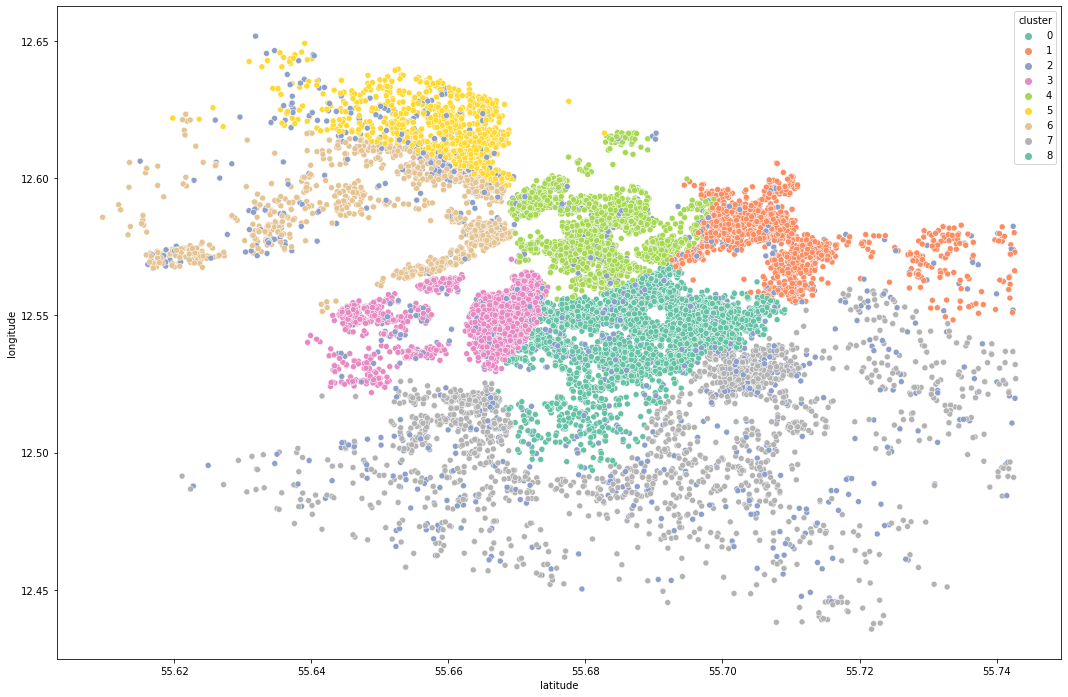

In [420]:
from sklearn.cluster import KMeans

# for kmeans, drop the binary columns
#kmeans_data = X_normalized.drop(columns=['amager_st', 'amager_vest', 'bispebjerg', 'brnshj-husum',
##       'frederiksberg', 'indre_by', 'nrrebro', 'sterbro', 'valby', 'vanlse',
#       'vesterbro-kongens_enghave', 'Entire ho    me/apt', 'Entire home/apt',
#       'Hotel room', 'Private room', 'Shared room'], axis=1)
price_normalized = (df_listings["price"] - df_listings["price"].min())/(df_listings["price"].max() - df_listings["price"].min())
kmeans_data = X_normalized.copy()

# Add normalized price to clustering data
kmeans_data["price"] = price_normalized
display(kmeans_data)

kmeans = KMeans(n_clusters=9)
labels = kmeans.fit_predict(kmeans_data) 

# Visualizing cluster centroids as lineplots:
centroids = kmeans.cluster_centers_
legends = []
for i, c in enumerate(centroids):
    plt.plot(c)
    legends.append(f"Centroid: {i+1}")
plt.legend(legends)
plt.show()

# Visualize cluster centroids with colored scatter:
# Using seaborn to get labels, hue must be a column in the dataframe
X["cluster"] = labels
df_listings["cluster"] = labels
plt.figure(figsize=(18,12))
sns.scatterplot(data=df_listings, x="latitude", y="longitude", hue="cluster", palette="Set2") #fin palette
display(X_normalized)
display(X)

Display the above cluster-wise

Text(0.5, 0.98, 'All cluster members projected onto lat-lon space')

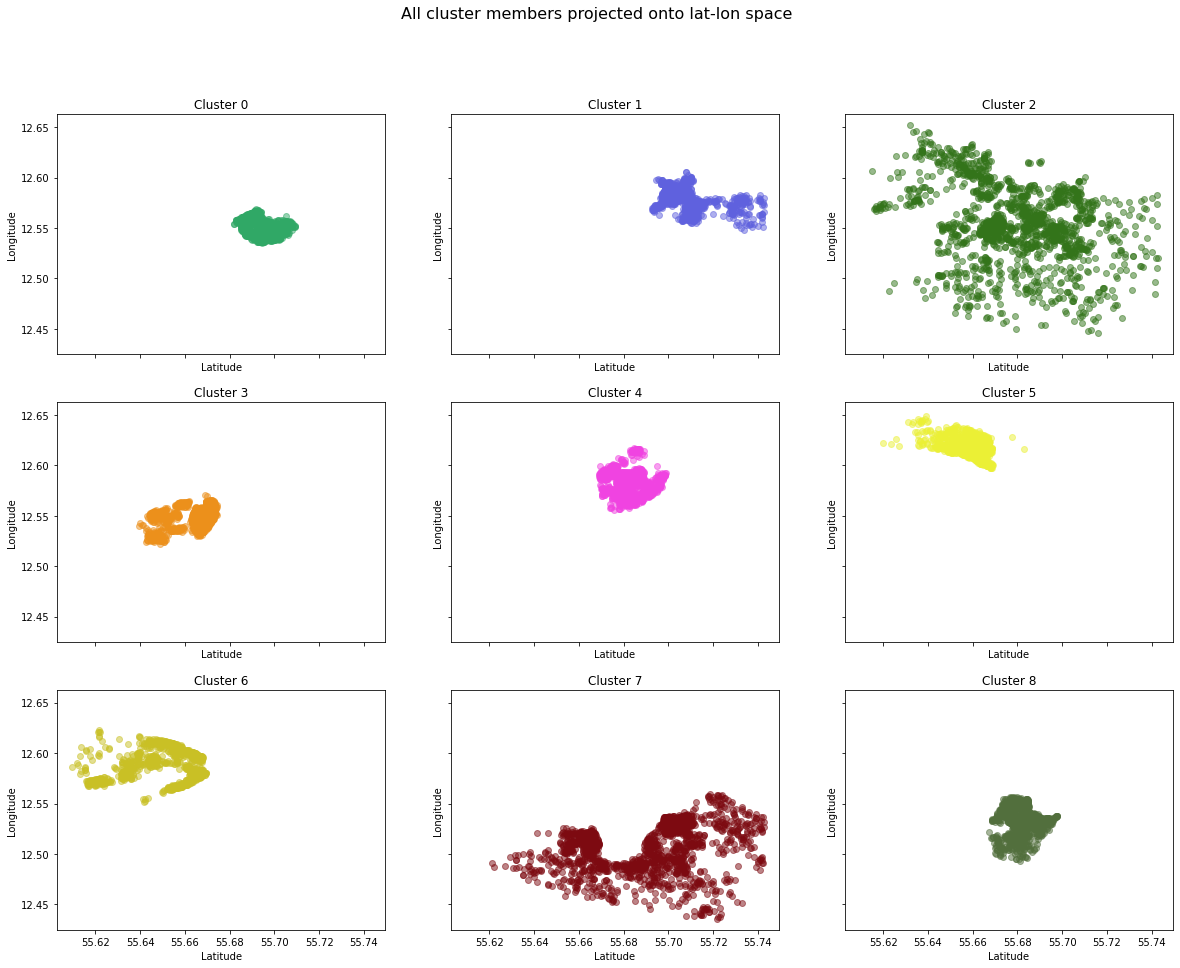

In [421]:
import random

# Random colors for plot
colors = []
for j in range(len(centroids)):
    r = lambda: random.randint(0,255)
    colors.append('#%02X%02X%02X' % (r(),r(),r()))


fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(20, 15))
for i, ax in zip(range(len(centroids)), axs.ravel()):
    data = df_listings.where(df_listings["cluster"] == i).dropna()
    ax.scatter(x=data["latitude"], y=data["longitude"], c=colors[i], alpha=0.5)
    ax.set_title(f"Cluster {i}")
    ax.set_xlabel("Latitude")
    ax.set_ylabel("Longitude")

fig.suptitle('All cluster members projected onto lat-lon space', fontsize=16)

In [422]:
# Now, X contain a cluster row, lets see if this improves performace of classifiers.
# dummies:
cluster = pd.get_dummies(X['cluster'])
X = pd.merge(X, cluster, left_index=True, right_index=True)
X = X.drop('cluster', 1)

In [423]:
X_normalized.head()

latitude  longitude  minimum_nights  number_of_reviews  reviews_per_month  \
0      0.58       0.52            0.00               0.24               0.04   
1      0.63       0.65            0.00               0.08               0.02   
2      0.50       0.65            0.00               0.42               0.09   
3      0.46       0.55            0.01               0.03               0.01   
4      0.43       0.55            0.00               0.03               0.01   

   calculated_host_listings_count  availability_365  number_of_reviews_ltm  \
0                            0.00              0.00                   0.01   
1                            0.00              0.83                   0.02   
2                            0.01              0.15                   0.01   
3                            0.00              0.16                   0.00   
4                            0.00              0.00                   0.00   

   amager_st  amager_vest  ...  distance to Nyhavn  distance to Tivoli  \
0          0            0  ...                0.26                0.18   
1          0            0  ...                0.16                0.21   
2          0            0  ...                0.10                0.04   
3          0            0  ...                0.23                0.08   
4          0            0  ...                0.25                0.10   

   distance to Rosenborg slot  distance to Frederiksberg slot  \
0                        0.17                            0.21   
1                        0.06                            0.42   
2                        0.10                            0.33   
3                        0.22                            0.18   
4                        0.25                            0.19   

   distance to Vor Frelsers kirke  distance to Christiansborg slot  \
0                            0.29                             0.22   
1                            0.22                             0.18   
2                            0.11                             0.03   
3                            0.22                             0.16   
4                            0.22                             0.18   

   distance to Torvehallerne  distance to Rundetårn  distance to Glyptoteket  \
0                       0.15                   0.19                     0.21   
1                       0.12                   0.13                     0.22   
2                       0.10                   0.06                     0.04   
3                       0.19                   0.18                     0.11   
4                       0.22                   0.21                     0.13   

   distance to Københavns zoo  
0                        0.24  
1                        0.44  
2                        0.36  
3                        0.22  
4                        0.23  

[5 rows x 36 columns]

In [424]:
X.head()

latitude  longitude  minimum_nights  number_of_reviews  reviews_per_month  \
0     55.69      12.55               3                172               1.08   
1     55.69      12.58               4                 59               0.55   
2     55.68      12.58               3                300               2.06   
3     55.67      12.56               7                 24               0.16   
4     55.67      12.56               3                 19               0.13   

   calculated_host_listings_count  availability_365  number_of_reviews_ltm  \
0                               1                 0                      4   
1                               1               303                      8   
2                               3                56                      7   
3                               1                59                      2   
4                               1                 0                      2   

   amager_st  amager_vest  ...  distance to Københavns zoo  0  1  2  3  4  5  \
0          0            0  ...                        2.36  1  0  0  0  0  0   
1          0            0  ...                        4.26  0  0  0  0  1  0   
2          0            0  ...                        3.51  0  0  0  0  1  0   
3          0            0  ...                        2.21  0  0  0  1  0  0   
4          0            0  ...                        2.29  0  0  0  1  0  0   

   6  7  8  
0  0  0  0  
1  0  0  0  
2  0  0  0  
3  0  0  0  
4  0  0  0  

[5 rows x 45 columns]

In [425]:
# Again, check lazypredict to see what classifiers perform best on our current split:
from lazypredict.Supervised import LazyClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.33,random_state =123)

clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)

print(models)

100%|██████████| 29/29 [01:14<00:00,  2.58s/it]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
LGBMClassifier                     0.71               0.71     0.71      0.71   
XGBClassifier                      0.71               0.71     0.71      0.71   
RandomForestClassifier             0.70               0.70     0.70      0.70   
AdaBoostClassifier                 0.69               0.69     0.69      0.69   
SVC                                0.69               0.69     0.69      0.69   
ExtraTreesClassifier               0.68               0.68     0.68      0.68   
CalibratedClassifierCV             0.68               0.68     0.68      0.68   
LinearSVC                          0.68               0.68     0.68      0.68   
LogisticRegression                 0.68               0.68     0.68      0.68   
NuSVC                              0.68               0.68     0.68      0.68   
BaggingClassifier           

Not any better with clusters as labels where the clusters are based on all the columns INCLUDING THE PRICE.... hmmmmmm
Okei kanskje prøve PCA eller adde noen helt annen data?